# Structured Dataset Assessment with Lens

### Find the code
This notebook can be found on [github](https://github.com/credo-ai/credoai_lens/blob/develop/docs/notebooks/lens_demos/dataset_assessment.ipynb).
```

## Contents

1. [What is Covered](#What-is-Covered)
2. [Introduction](#Introduction)
3. [Dataset](#Dataset)
4. [Running Lens](#Running-Lens)
    1. [Gender as Sensitive Feature](#Gender-as-SensitiveFeature)
    2. [Race as Sensitive Feature](#Race-as-Sensitive-Feature)

## What is Covered <a name="What-is-Covered"></a>
* **Domain:**
  * Applications that rely on structured datasets with sensitive attributes.


* **ML task:**
  * Model training, validation, and testing with structured datasets.

## Introduction <a name="Introduction"></a>
Structured data conforms to a tabular format with relationship between the different rows and columns. Many machine learning models are trained, validated, and tested on structured datasets.

Biases in data might result in biased algorithmic outcomes. Structured Dataset Assessment tool enables the assessment of a structured dataset for biases. It assesses a dataset for the representation of demographic groups and presence of proxies. It is demonstrated here on the [Census Adult Dataset](https://archive.ics.uci.edu/ml/datasets/adult).

## Dataset <a name="Dataset"></a>
The [Census Adult Dataset](https://archive.ics.uci.edu/ml/datasets/adult) is from the Census Bureau and the label is whether a given adult makes more than $50K a year based attributes such as sex and education.

The dataset provides 13 input variables that are a mixture of categorical, ordinal, and numerical data types. The complete list of variables is as follows:

Age, Workclass, Education, Education Number of Years, Marital-status, Occupation, Relationship, Race, Sex, Capital-gain, Capital-loss, Hours-per-week, and Native-country.

In [1]:
# Imports for demo data
from credoai.data import fetch_censusincome

# Base Lens imports
import credoai.lens as cl

In [2]:
data = fetch_censusincome()
df = data['data'].copy()
df['target'] = data['target']

In [3]:
df.head(3)

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
0,39.0,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,0
1,50.0,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,0
2,38.0,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,0


The dataset contains missing values that are marked with a question mark character (?). Let's drop samples with missing values.

In [4]:
df = df[(df != '?').all(axis=1)]

## Running Lens <a name="Running-Lens"></a>
First step is creating a Lens CredoData artifact. This will hold the structured dataset and the meta information needed for doing the assessment. CredoData has the following paramters:

`name` : an arbitrary name that you want to assign to the object (str)


`data` : dataset dataframe that includes all features and labels (pd.DataFrame)


`sensitive_feature_key` : name of the sensitive feature column in your data, like 'race' or 'gender' (str)


`label_key` : name of the label column in your data, like 'label' (str)


`categorical_features_keys` : names of the categorical features in your data (including the sensitive feature, if applicable). If not provided, Lens will automatically estimate them (list[str], optional )

### Sex as Sensitive Feature  <a name="Gender-as-Sensitive-Feature"></a>
Let's perform the assessment with `sex` as the sensitive attributes. We also specify the categorical features as it is always safer to do so when they are known.

In [5]:
sensitive_feature_key = 'sex'
label_key = 'target'
categorical_features_keys = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']

# Set up the data artifact
credo_data = cl.CredoData(name='census-income',
                          data=df, 
                          sensitive_feature_key=sensitive_feature_key,
                          label_key=label_key,
                          categorical_features_keys=categorical_features_keys)

Let's run the assessment now. The output `results` object will contain the assessment results. 

In [6]:
lens = cl.Lens(data=credo_data)
results = lens.run_assessments()

Now we use the Lens visualization capabilities to visualize the assessment results.

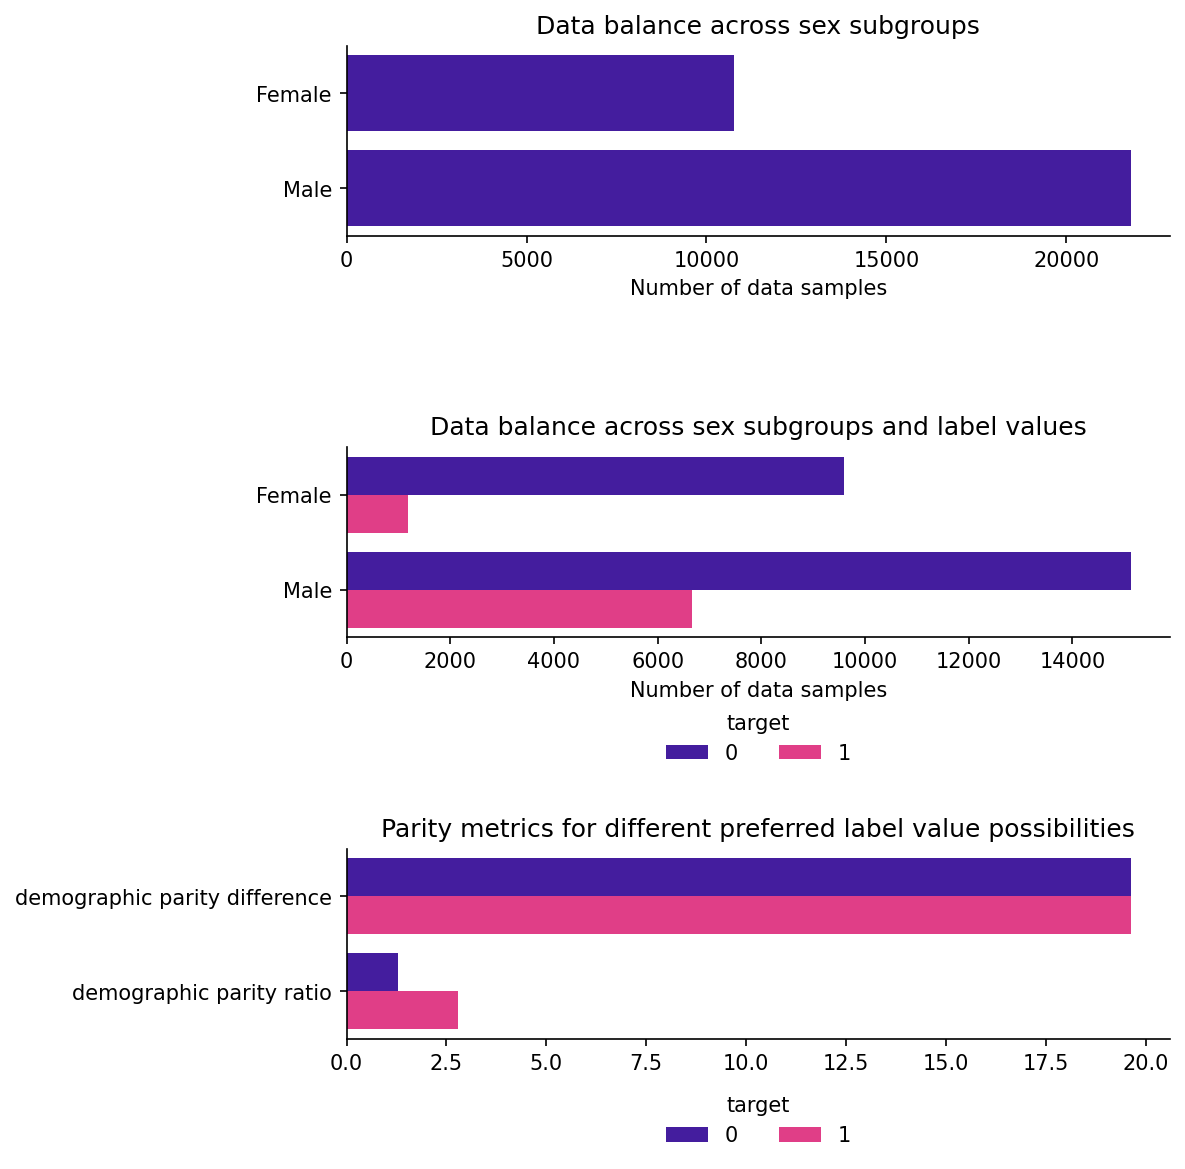

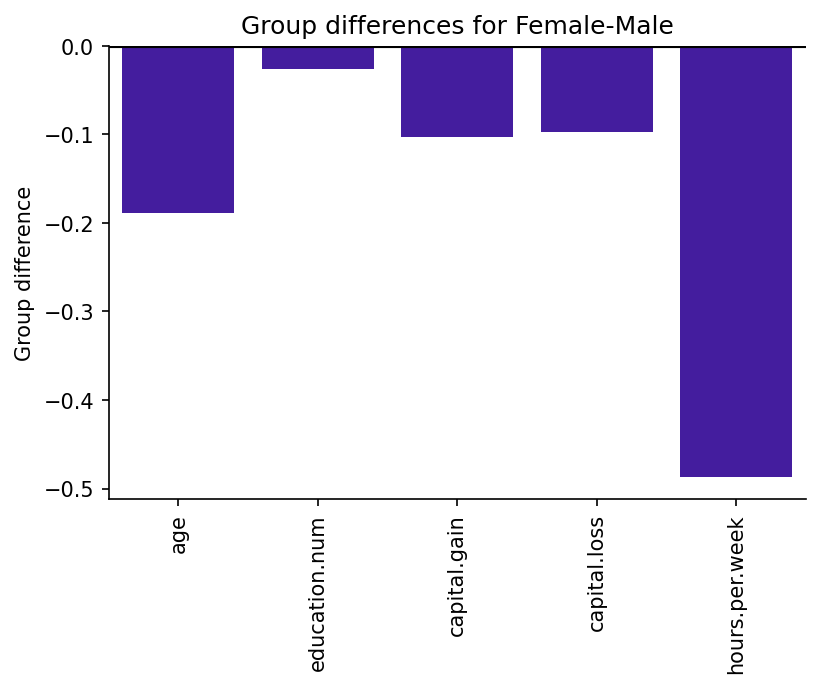

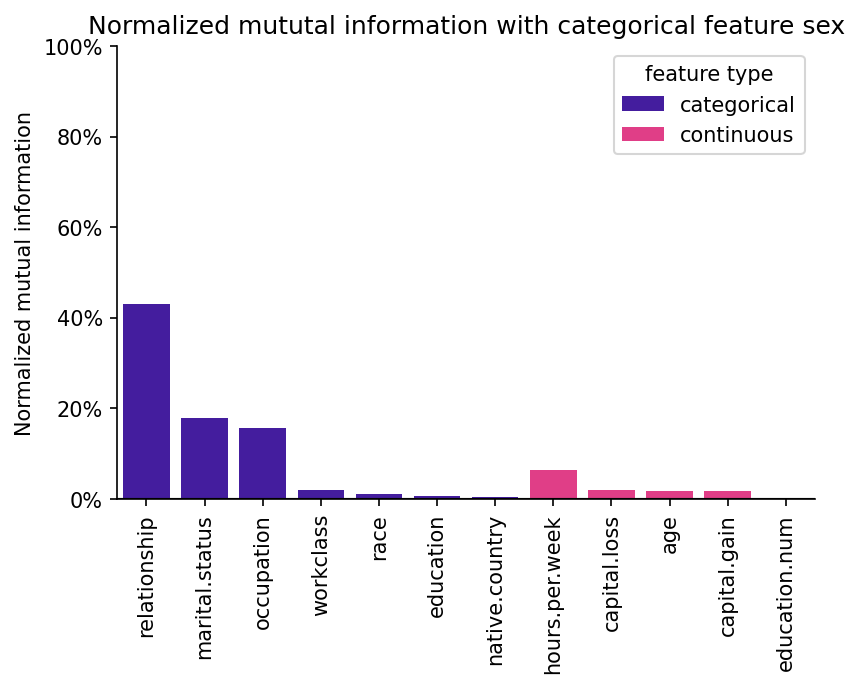

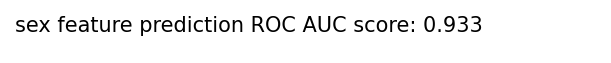

In [7]:
reports = lens.create_reports()

Let's go through the results one by one and interpret them.

#### Data balance
The data balance assessment results help us gain insights into how the demographic groups are represented in the dataset. They are illustrated in the first figure.

The first subplot shows that males are represented twice as more than females. Considering the target value of 1 (income greater than 50K) as the preferred label value, we can see from the second subplot that a higher proportion of males have a preferred label 1. This proportion for males (`m`) and females (`f`) can be formulated as

$$q_m = \frac{n_m^{(1)}}{n_m},  \quad q_f = \frac{n_f^{(1)}}{n_f}$$

Demographic parity difference *DPD* (also called statistical parity) and demographic parity ratio *DPR* (also called disparate impact) are the difference and ratio of these proportions. They are illustrated in the third subplot.

$$DPD = \frac{q_m}{q_f}, \quad DPR = q_m - q_f$$

*DPD=0* and *DPR=1* indicate demographic parity.

#### Group differences 
The group difference results shown in second figure are standardized mean differences calculated separately for each feature. For every numeric feature, its means across the groups are calculated and their difference is divided by the feature's standard deviation:

$$\theta =\frac {\mu_m - \mu_f}{\sigma }$$

It shows how the distribution of other features are different across the demographic groups. It is closely related to [effect size](https://en.wikipedia.org/wiki/Effect_size).

#### Proxy assessment 
Even if we don’t give the model access to a sensitive attribute directly, the model may learn to discriminate anyway by using a proxy that is correlated with the protected attribute. The proxy assessment stage assess the dataset for the presence of proxies in the dataset.

**- Mutual information**

[Mutual information](https://en.wikipedia.org/wiki/Mutual_information) is the "amount of information" obtained about the sensitive feature by observing another feature. The mutual information values range over the interval [0, ∞). They are therefore normalized via dividing by the mutual information between the sensitive feature and itself.

The third figure indicates that 'relationship' feature has a 40% normalized mutual information with 'sex'. This feature therefore may be better omitted or used with caution for training purposes.

**- Sensitive feature predictability**

Other features collectively may serve as a proxy for the sensitive features. To assess this, Lens trains a gradient boosting model on the features to predict the sensitive attribute. Then it determines cross-validated ROC-AUC score. The score quantifies the performance of this prediction. A high score means the data collectively serves as a proxy. The ROC-AUC score values range over the interval [0, 1].

The last figure indicates that this score is 0.93, which is significantly high.

### Race as Sensitive Feature  <a name="Race-as-Sensitive-Feature"></a>
Let's repeat the assessment with `race` as the sensitive attributes.

In [8]:
sensitive_feature_key = 'race'
label_key = 'target'
categorical_features_keys = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']

# Set up the data artifact
credo_data = cl.CredoData(name='census-income',
                          data=df, 
                          sensitive_feature_key=sensitive_feature_key,
                          label_key=label_key,
                          categorical_features_keys=categorical_features_keys)

In [9]:
lens = cl.Lens(data=credo_data)
results = lens.run_assessments()

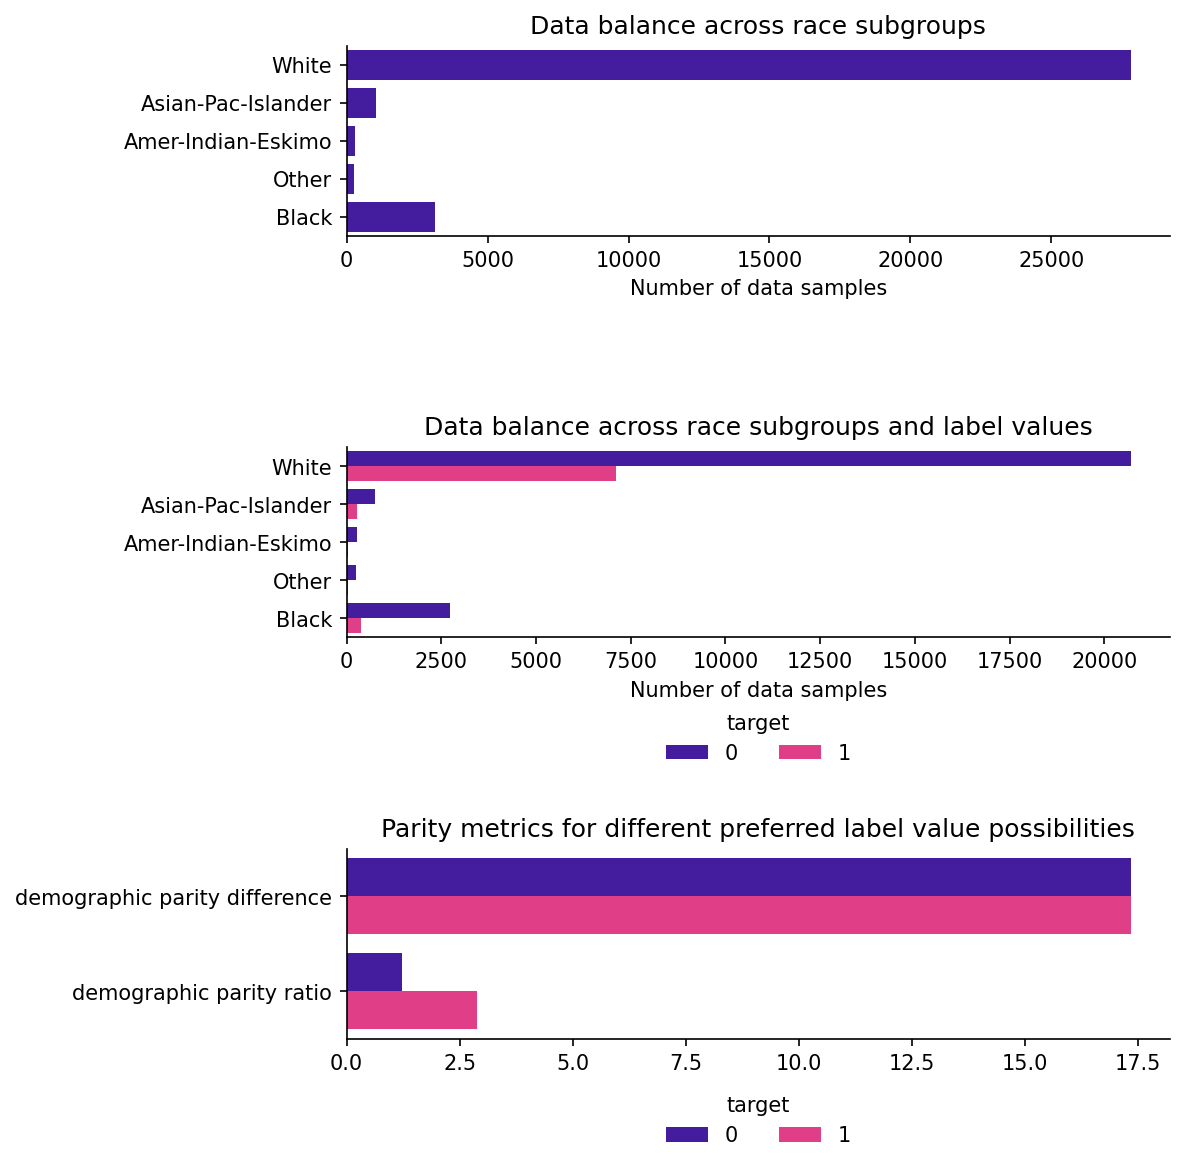

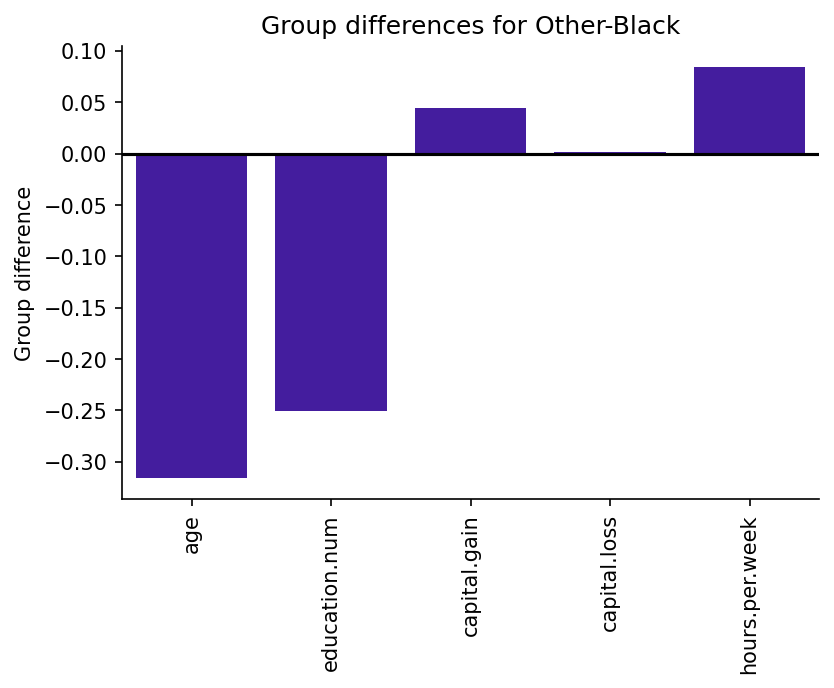

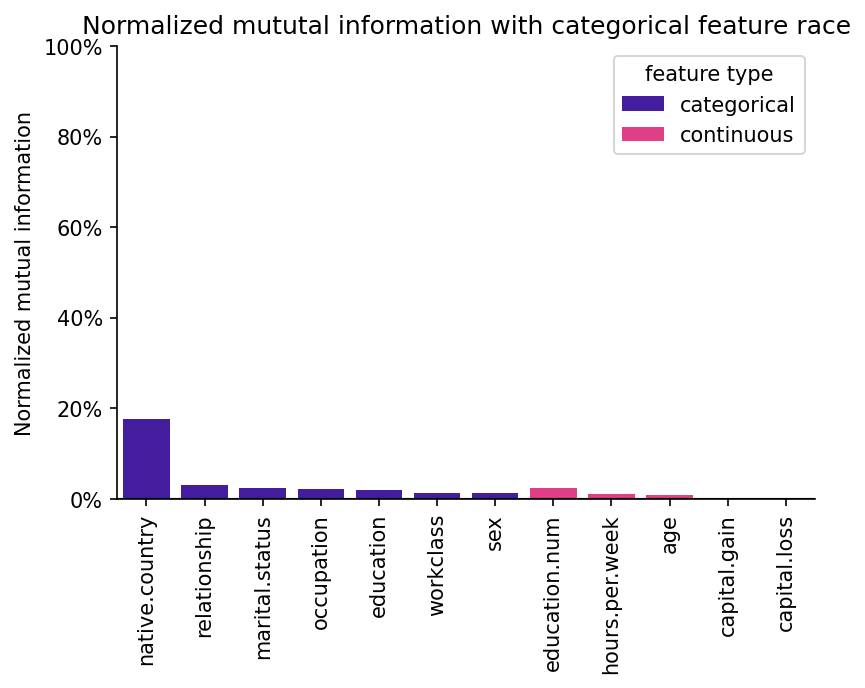

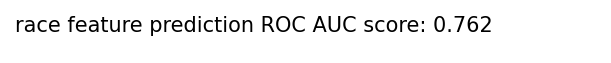

In [10]:
reports = lens.create_reports()

The results can be interpreted similarly to `sex` features. There are, however, some noteworthy differences.

There are more than two groups in this feature. The data imbalance is more significant. When there are more than two groups, like here, the demographic parity metrics can be calculated for different group combinations. Lens visualizes the maximum values only, but the values can be accessed in the output `results` variable above.

Similarly, the group differences for the group combination with the maximum total absolute value is visualized. The output `results` variable contains values for all the combinations.

`native.country` has the highest normalized mutual information with `race`. The `race` predictability ROC-AUC score is 0.763. Since `race` feature here is multi-class, one-vs-one configuration is used here for the calculations and is also insensitive to class imbalance. It computes the average ROC-AUC of all possible pairwise combinations of classes. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) for more details.